In [1]:
# First version: 18th of March 2022
# Author: Evangelos Papoutsellis
# Copyright 2022 Science and Techonology Facilities Council

# This software was developed during the Math+ “Maths meets Image” hackathon 2022.

# Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless
# required by applicable law or agreed to in writing, software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License
# for the specific language governing permissions and limitations under the License.


from cil.optimisation.algorithms import PDHG
import sirf.Gadgetron as mr
from cil.optimisation.functions import L2NormSquared, BlockFunction, L1Norm, ZeroFunction
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.optimisation.operators import FiniteDifferenceOperator, BlockOperator
from cil.utilities.jupyter import islicer

The `.abs` method in SIRF creates some problems so we need to overwrite some methods where this method is used. 


In [2]:
#################
# overwrite because the abs method of SIRF does not work well
# return complex
def new_call_l1(self, x):
    
    tmp = np.abs(x.as_array()).sum()
    return tmp
L1Norm.__call__ = new_call_l1
#################


# fix convex_conjguate for the L21NormSquared, because we get complex vals using the dot product
def convex_conjugate_l2squared(self, x):             
    if self.b is not None:        
        tmp = (0.25*((np.abs((x + 2*self.b).as_array())**2) - 4.*np.abs(self.b.as_array())**2)).sum()
    else:
        pass
    return tmp
L2NormSquared.convex_conjugate = convex_conjugate_l2squared 


# input has no attribute geometry, this is for SIRF objects and CIL
# compatibility
def check_input(self, input):
    input.geometry = input.shape
    if len(input.geometry) > 3:
        raise ValueError('{} cannot work on more than 3D. Got {}'.format(self.__class__.__name__, input.geometry.length))
FGP_TV.check_input = check_input


# abs method for SIRF objects does not have out as kwarg
# therefore soft-shrinkage from the L1Norm fails.
# fails at the proximal method
# create a proximal_conjugate method for L1Norm to overwrite it


import numpy as np
def new_proximal_conjugate_l1(self,x, tau, out=None):
    
    if out is not None:
        
        tmp = x.as_array()
        out.fill(tmp/np.maximum(np.abs(tmp), 1.0))
L1Norm.proximal_conjugate = new_proximal_conjugate_l1        

def new_convex_conjugate(self,x):
    # in theory this is the indicator function of the L^{\infty} norm
    # 0 if \|x\|_{\infty}<=1 or infinity
    # however this does not hold in practice and we could have infinity values
    # it is better to return x.abs().max()-1 expecting to be close to 0 in many iterations
    return np.max(np.abs(x.as_array()))-1.0
L1Norm.convex_conjugate = new_convex_conjugate 


# as above, see also here https://github.com/TomographicImaging/CIL/blob/26f863aea98b339cc4f8f53f0d33f61a44742d5c/Wrappers/Python/cil/optimisation/functions/Function.py#L525
def convex_conjugate_zero_function(self, x):  
    
    return np.maximum(x.as_array(),0).sum()

ZeroFunction.convex_conjugate = new_convex_conjugate

def call_l2squared(self, x):
     
    return (np.abs((x - self.b).as_array())**2).sum()
L2NormSquared.__call__ = call_l2squared

    

In [3]:
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar()
    plt.title(title)
    plt.axis("off")


def crop_and_fill(templ_im, vol):
    """Crop volumetric image data and replace image content in template image object"""
    # Get size of template image and crop
    idim_orig = templ_im.as_array().shape
    idim = (1,)*(3-len(idim_orig)) + idim_orig
    offset = (numpy.array(vol.shape) - numpy.array(idim)) // 2
    vol = vol[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1], offset[2]:offset[2]+idim[2]]
    
    # Make a copy of the template to ensure we do not overwrite it
    templ_im_out = templ_im.copy()
    
    # Fill image content 
    templ_im_out.fill(numpy.reshape(vol, idim_orig))
    return(templ_im_out)

In [4]:
# Load MR AcquisitionData
# mr_acq = mr.AcquisitionData('../cine_64_32ph.h5')
mr_acq = mr.AcquisitionData('johannes_y_4.h5') # undersampled data by Johannes
# preprocessed_data = mr.preprocess_acquisition_data(mr_acq)
preprocessed_data = mr_acq
preprocessed_data.sort()


Started reading acquisitions from johannes_y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from johannes_y_4.h5


In [5]:
# Calculate image
recon = mr.FullySampledReconstructor()
recon.set_input(preprocessed_data)
recon.process()
im_mr = recon.get_output()

In [6]:
# 4. create AcquisitionModel
acq_mod_mr = mr.AcquisitionModel(preprocessed_data, im_mr)
csm = mr.CoilSensitivityData()
csm.calculate(preprocessed_data)
acq_mod_mr.set_coil_sensitivity_maps(csm)

# Dynamic MR reconstruction with anisotropic spatiotemporal TV, i.e. uncouple all dims.

$$ \underset{u}{\mathrm{argmin}} \big\{\| Au - g \|^{2} +  \|\lambda_{1} \partial_{t}  u\|_{1} + \|\lambda_{2} \partial_{y}   u\|_{1} +  \|\lambda_{3} \partial_{x}   u\|_{1}\}$$


$$  \lambda_{i}, i = 1,\dots,3 $$ are spatially & temporally dependent.

In [7]:
### Let's try with spatially dependent lambdas, need to remove the geometry attirbutes in
### in the diagonal operator

from cil.optimisation.functions import Function
import numbers
# weighted L1 Norm for the lambdas
class WeightedL1Norm(Function):

    def __init__(self, weight):
        super(WeightedL1Norm, self).__init__()
        self.weight = weight
    
    def __call__(self,x):
        
        if isinstance(self.weight, numbers.Number):
            return (self.weight * np.abs(x.as_array())).sum()
        else:
            return (self.weight.as_array() * np.abs(x.as_array())).sum()
        return tmp
            
    def convex_conjugate(self, x):
        return 0.

    def proximal_conjugate(self, x, tau, out=None):
        
        if isinstance(self.weight, numbers.Number):
            tmp_weight = self.weight
        else:
            tmp_weight = self.weight.as_array()
        
        tmp = x.as_array()
        tmp1 = np.maximum(np.abs(tmp/tmp_weight), 1.0)        
        out.fill(tmp/tmp1)
                
    
lambda1 = 1e5#im_mr.allocate(10)  # for time but arrays
lambda2 = 1e5#im_mr.allocate(1e5)  # for spatial y
lambda3 = 1e5#im_mr.allocate(1e5)  # for spatial x

F = L2NormSquared(b=mr_acq)

Dt = FiniteDifferenceOperator(im_mr, direction=0)
Dy = FiniteDifferenceOperator(im_mr, direction=1)
Dx = FiniteDifferenceOperator(im_mr, direction=2)

K = BlockOperator(acq_mod_mr, Dt, Dy, Dx)
F = BlockFunction(L2NormSquared(b=mr_acq), WeightedL1Norm(lambda1), WeightedL1Norm(lambda2), WeightedL1Norm(lambda3))
G = ZeroFunction()

normK = 3.15090734179149 #K.norm() 
sigma = 1./normK
tau = 1./normK

pdhg_implicit_weights_spatiotemporal = PDHG(f = F, g = G, operator = K, 
            max_iteration = 500, sigma=sigma, tau=tau,
            update_objective_interval = 50, check_convergence=False)
pdhg_implicit_weights_spatiotemporal.run(verbose=2) # verbose to 0 do reduce computation time and avoid computing primal/dual objective
                             # verbose to 1, computes only primal objective.



PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    3.39433e+09   1.00000e+00    3.39433e+09
       50        500         0.530    1.45283e+11   4.43530e+08    1.44840e+11
      100        500         0.530    1.03452e+11   5.51069e+08    1.02901e+11
      150        500         0.528    8.76408e+10   6.24080e+08    8.70167e+10
      200        500         0.526    7.74824e+10   6.79417e+08    7.68030e+10
      250        500         0.523    6.98643e+10   7.24016e+08    6.91403e+10
      300        500         0.524    6.38431e+10   7.61144e+08    6.30819e+10
      350        500         0.521    5.89126e+10   7.92681e+08    5.81200e+10
      400        500         0.520    5.47780e+10   8.19840e+08    5.39582e+10
      450        500         0.520    5.12387e+10   8.43471e+08    5.03952e+10
      500        500

interactive(children=(IntSlider(value=6, continuous_update=False, description='X', max=11), FloatRangeSlider(v…

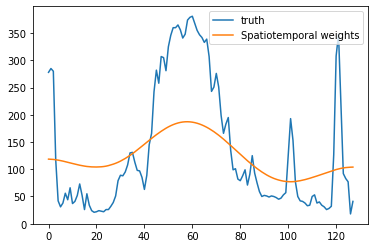

For large lambdas we expect to have a solution close to the mean value 105.66776529947917 


In [10]:
sol = pdhg_implicit_weights_spatiotemporal.solution.abs()
islicer(sol, direction=0)

import nibabel as nib
gtruth = nib.load('../../johannes_img_4.nii').get_fdata() #get a numpy

import matplotlib.pyplot as plt
plt.figure()
plt.plot(gtruth[10,50,:], label="truth")
plt.plot(sol.as_array()[10,50,:], label="Spatiotemporal weights")
plt.legend()
plt.show()

print("For large lambdas we expect to have a solution close to the mean value {} ".format(np.mean(gtruth)))

### misc code

In [11]:
# F = L2NormSquared(b=mr_acq)

# lambda1 = 10. # for time
# lambda2 = 1e5 # for spatial y
# lambda3 = 1e5 # for spatial x


# Dt = lambda1*FiniteDifferenceOperator(im_mr, direction=0)
# Dy = lambda2*FiniteDifferenceOperator(im_mr, direction=1)
# Dx = lambda3*FiniteDifferenceOperator(im_mr, direction=2)

# K = BlockOperator(acq_mod_mr, Dt, Dy, Dx)
# F = BlockFunction(L2NormSquared(b=mr_acq), L1Norm(), L1Norm(), L1Norm())
# G = ZeroFunction()

# normK = K.norm() # norm depends on the weights
# sigma = 1./normK
# tau = 1./normK

# pdhg_implicit_different_weights= PDHG(f = F, g = G, operator = K, 
#             max_iteration = 100, sigma=sigma, tau=tau,
#             update_objective_interval = 10, check_convergence=False)
# pdhg_implicit_different_weights.run(verbose=2) # verbose to 0 do reduce computation time and avoid computing primal/dual objective
#                              # verbose to 1, computes only primal objective.

# sol = np.abs(pdhg_implicit_different_weights.solution.as_array())
# islicer(sol, direction=0)
